# K Means practice

Gotta apply k means on the dataset and find out clusters of people depending on various features.

In [99]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# Importing data
raw_train_df = pd.read_csv("data/train.csv")
raw_test_df = pd.read_csv("data/test.csv")

print(raw_train_df.columns)

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')


In [100]:
for column in raw_train_df.columns:
    print(f"{column}: {pd.unique(raw_train_df[column])}")

ID: [462809 462643 466315 ... 465406 467299 461879]
Gender: ['Male' 'Female']
Ever_Married: ['No' 'Yes' nan]
Age: [22 38 67 40 56 32 33 61 55 26 19 70 58 41 31 79 49 18 36 35 45 42 83 27
 28 47 29 57 76 25 72 48 74 59 39 51 30 63 52 60 68 86 50 43 80 37 46 69
 78 71 82 23 20 85 21 53 62 75 65 89 66 73 77 87 84 81 88]
Graduated: ['No' 'Yes' nan]
Profession: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
Work_Experience: [ 1. nan  0.  4.  9. 12.  3. 13.  5.  8. 14.  7.  2.  6. 10. 11.]
Spending_Score: ['Low' 'Average' 'High']
Family_Size: [ 4.  3.  1.  2.  6. nan  5.  8.  7.  9.]
Var_1: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']
Segmentation: ['D' 'A' 'B' 'C']


In [101]:
# eliminating all rows with atleast one "nan" entry
raw_train_df = raw_train_df.dropna()
raw_test_df = raw_test_df.dropna()

for column in raw_train_df.columns:
    print(f"{column}: {pd.unique(raw_train_df[column])}")

ID: [462809 466315 461735 ... 465406 467299 461879]
Gender: ['Male' 'Female']
Ever_Married: ['No' 'Yes']
Age: [22 67 56 32 33 61 55 26 19 58 41 31 79 49 18 36 35 45 42 83 27 28 47 40
 57 76 25 48 74 59 51 30 63 52 39 38 60 68 86 43 80 37 46 72 69 50 29 71
 78 82 70 23 20 21 53 75 65 89 62 66 73 77 87 84 88 85 81]
Graduated: ['No' 'Yes']
Profession: ['Healthcare' 'Engineer' 'Lawyer' 'Artist' 'Doctor' 'Homemaker'
 'Entertainment' 'Marketing' 'Executive']
Work_Experience: [ 1.  0.  4.  9. 12.  3. 13.  5.  8. 14.  7.  2.  6. 10. 11.]
Spending_Score: ['Low' 'High' 'Average']
Family_Size: [4. 1. 2. 3. 5. 6. 8. 7. 9.]
Var_1: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']
Segmentation: ['D' 'B' 'C' 'A']


In [102]:
# X = test and train  *ONLY*
def init_df(X):
    # Removing "Var_1, Segmentation"
    X.drop("ID", axis=1, inplace=True)
    X.drop("Var_1", axis=1, inplace=True)
    X.drop("Segmentation", axis=1, inplace=True)

    # Gender
    X.loc[X["Gender"] == "Male", "Gender"] = 0
    X.loc[X["Gender"] == "Female", "Gender"] = 1

    # Ever_Married
    X.loc[X["Ever_Married"] == "No", "Ever_Married"] = 0
    X.loc[X["Ever_Married"] == "Yes", "Ever_Married"] = 1

    # Age
    age_mean = np.mean(X["Age"])
    age_std_deviation = np.std(X["Age"])

    X["Age"] = (X["Age"] - age_mean) / age_std_deviation

    # Graduated
    X.loc[X["Graduated"] == "No", "Graduated"] = 0
    X.loc[X["Graduated"] == "Yes", "Graduated"] = 1

    # Profession - One-hot encoding
    encoded_profession = pd.get_dummies(X["Profession"]).astype(int)  # .get_dummies does one-hot encoding
    X = pd.concat([X, encoded_profession], axis=1)
    X.drop("Profession", axis=1, inplace=True)

    # Work experence
    work_mean = np.mean(X["Work_Experience"])
    work_std_deviation = np.std(X["Work_Experience"])

    X["Work_Experience"] = (X["Work_Experience"] - work_mean) / work_std_deviation

    # Spending score
    X.loc[X["Spending_Score"] == "Low", "Spending_Score"] = 0
    X.loc[X["Spending_Score"] == "Average", "Spending_Score"] = 0.5
    X.loc[X["Spending_Score"] == "High", "Spending_Score"] = 1

    # Family_Size
    fam_mean = np.mean(X["Family_Size"])
    fam_std_deviation = np.std(X["Family_Size"])

    X["Family_Size"] = (X["Family_Size"] - fam_mean) / fam_std_deviation

    return np.array(X)

In [103]:
def update_clusters(X, clusters, cluster_centroids):
    for pt_i in range(X.shape[0]):
        distances = []
        for cluster_i in range(len(clusters)):
            distance_vector = cluster_centroids[cluster_i, :] - X[pt_i, :]
            distance = np.linalg.norm(distance_vector)
            distances.append(distance)
        
        nearest_cluster_i = distances.index(min(distances))
        clusters[nearest_cluster_i].append(X[pt_i, :])


def update_centroids(X, clusters, cluster_centroids):
    n_features = X.shape[1]
    for cluster_i in range(cluster_centroids.shape[0]):
        x = np.array(clusters[cluster_i]).reshape(len(clusters[cluster_i]), n_features)
        x_mean = np.mean(x, axis=0).reshape(1, -1)

        # Update centroids
        cluster_centroids[cluster_i, :] = x_mean


def compute_cost(X, clusters, cluster_centroids):
    cost = 0

    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        centroid = cluster_centroids[i, :]

        distances = np.linalg.norm(cluster_points - centroid)
        cluster_cost = np.sum(distances)
        cost += cluster_cost

    return cost


def clusterize(X, n_centroids):
    n_features = X.shape[1]
    cluster_centroids = np.random.uniform(-0.1, 0.1, (n_centroids, n_features))
    clusters = [[] for _ in range(n_centroids)]

    iterations = 50
    for _ in range(iterations):
        # Step 1: Assign each "person" its centroid
        update_clusters(X, clusters, cluster_centroids)

        # Step 2: Find center of each cluster
        update_centroids(X, clusters, cluster_centroids)

        cost = compute_cost(X, clusters, cluster_centroids)
        costs.append(cost)

    return clusters, cluster_centroids, costs

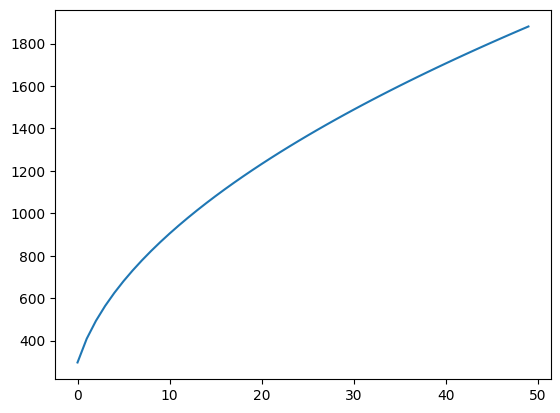

In [104]:
if __name__ == "__main__":
    X_train = raw_train_df.copy(); X_test = raw_test_df.copy()

    X_train = init_df(X_train); X_test = init_df(X_test)

    n_clusters = 4
    costs = []
    clusters, cluster_centroids, costs = clusterize(X_train, n_clusters)

    x = np.arange(len(costs))
    plt.plot(x, costs)
    plt.show()

    """
    max_n_iterate = 10
    costs = []
    for n_centroids in range(max_n_iterate):
        cluster_centroids = clusterize(X_train, n_centroids)
        cost = get_cost(cluster_centroids, X_test)
        costs.append(cost)
    """
